In [10]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, TimeSeriesSplit,
                                     cross_val_score)
from tensorflow import keras
from tensorflow.keras import layers

sns.set_theme("paper")
pd.options.mode.chained_assignment = None
pd.options.display.float_format = "{:.2f}".format

In [11]:
X_TEST_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "X_test.parquet"
)
y_TEST_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "y_test.parquet"
)

X_TRAIN_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "X_train.parquet"
)
y_TRAIN_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "y_train.parquet"
)
MODEL_SAVE_DIR = Path(Path.cwd().parent, "models", "saved_model")

In [12]:
X_test = pd.read_parquet(X_TEST_LOAD_DIR)
y_test = pd.read_parquet(y_TEST_LOAD_DIR)
y_train = pd.read_parquet(y_TRAIN_LOAD_DIR)
X_train = pd.read_parquet(X_TRAIN_LOAD_DIR)
y_test = np.ravel(y_test)  # Ravel required for ridge regression
y_train = np.ravel(y_train)

In [4]:
print(f"y_train: {y_train.shape}")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

y_train: (9799929,)
X_train: (9799929, 19)
X_test: (4899964, 19)
y_test: (4899964,)


# Modelling
## Baseline metrics

It's hard to understand how 'good' a result is without a sense of the distribution of target values. 

In [5]:
np.mean(y_test)

1704.9147

In [6]:
np.median(y_test)

1247.8164

In [10]:
def calculate_metrics(y_test: pd.DataFrame, y_pred: np.ndarray) -> dict:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred, squared=True)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(
        f"""
          RMSE: {rmse:.2f} 
          MSE: {mse:.2f}  
          MAE: {mae:.2f}  
          R2: {r2:.2f}"""
    )
    return {"RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}


def calculate_cv_metrics(model, X_train, y_train, n_splits: int = 5) -> dict:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse = np.sqrt(
        -cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error"
        )
    )
    R2 = cross_val_score(model, X_train, y_train, cv=tscv, scoring="r2")
    return {"RMSE": np.mean(rmse), "R2": np.mean(R2)}

In [8]:
models = [Ridge(alpha=100), LinearRegression(), BayesianRidge()]
# Lasso Regression does not converge
results = []
timings = []

In [9]:
RUN_LINEAR_MODELS = False  # Flag to avoid running with every notebook run
if RUN_LINEAR_MODELS:
    for model in models:
        start = time.time()
        model_result = calculate_cv_metrics(model, X_train, y_train)
        end = time.time()
        model_time = end - start
        timings.append(model_time)
        results.append({model: model_result})
        print(f"model {model} took {round(model_time, 2)} seconds")

Initial results are not great, and are on par with the mean load value for the test set. Let's try some hyperparameter tuning and see if we can improve. We'll usr ridge regression since it was fastest and the results were all similar. 

## Ridge Hyperparameter Tuning

In [10]:
ridge = Ridge()
param_search = {"alpha": [0.1, 1, 10, 100, 1000], "solver": ["cholesky", "lsqr"]}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(
    estimator=ridge,
    cv=tscv,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
)

In [11]:
gsearch.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 10, 100, 1000],
                         'solver': ['cholesky', 'lsqr']},
             scoring='neg_root_mean_squared_error')

In [12]:
print(f"best estimator: {gsearch.best_estimator_}")
print(f"best score: {gsearch.best_score_}")

best estimator: Ridge(alpha=100, solver='cholesky')
best score: -1253.0260983130909


In [13]:
y_pred = gsearch.predict(X_test)

In [14]:
calculate_metrics(y_test, y_pred)


          RMSE: 1184.10 
          MSE: 1402097.65  
          MAE: 879.07  
          R2: 0.36


{'RMSE': 1184.1020449786681,
 'MSE': 1402097.6529226636,
 'MAE': 879.0697951226633,
 'R2': 0.3597407713577372}

A fairly high alpha value means the algorithm is possibly just overfitting and forcing an average. We can try to reduce overfitting by reducing the number of features. We can inspect the coefficient weightings to see which ones are most important

### Reducing overfitting

In [15]:
gsearch.best_estimator_.coef_

array([ 9.18306478e+03, -1.07536484e+03, -7.08564326e+03, -6.29064955e+02,
        7.62781995e+02,  3.62149358e+02, -8.33117086e+02, -3.15776055e+02,
       -1.49563740e+01,  5.85024046e-01,  8.75379057e+01, -7.96681523e+01,
        2.35144189e+02,  4.39412032e+00, -1.98562494e+01,  7.71797635e-01,
       -3.84186112e-02, -1.05611090e+02, -1.21326317e+02])

<BarContainer object of 19 artists>

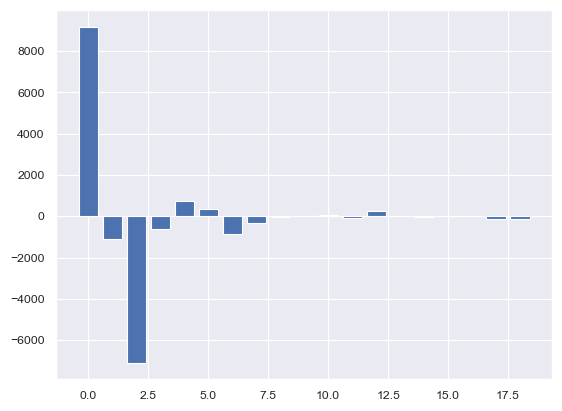

In [16]:
importance = gsearch.best_estimator_.coef_
plt.bar([x for x in range(len(importance))], importance)

In [17]:
importance_dict = dict(zip(range(len(importance)), abs(importance)))
importance_dict = {
    k: v
    for k, v in sorted(importance_dict.items(), reverse=True, key=lambda item: item[1])
}
importance_dict

{0: 9183.06477866833,
 2: 7085.64326430659,
 1: 1075.3648374878094,
 6: 833.1170860256691,
 4: 762.7819947050075,
 3: 629.0649552139877,
 5: 362.14935846932923,
 7: 315.776055342397,
 12: 235.14418931227638,
 18: 121.32631721327596,
 17: 105.61109039503295,
 10: 87.53790572702252,
 11: 79.66815230782518,
 14: 19.856249395245875,
 8: 14.956373992666531,
 13: 4.394120318336875,
 15: 0.7717976348551865,
 9: 0.5850240456990444,
 16: 0.03841861116012413}

I'll try removing all features with coefficients less than 600 and check the effect on ridge regression. 

In [18]:
features_to_keep = tuple({k: v for k, v in importance_dict.items() if v > 600}.keys())
features_to_keep

(0, 2, 1, 6, 4, 3)

In [33]:
cols_idx_dict = dict(zip(range(len(X_train.columns)), X_train.columns.to_list()))
cols_idx_dict

{0: 'Min Temp',
 1: 'Max Temp',
 2: 'Min Wet Bulb',
 3: 'Max Wet Bulb',
 4: 'Time Stamp',
 5: 'PTID',
 6: 'Year',
 7: 'Month',
 8: 'Day',
 9: 'Minute',
 10: 'Hour',
 11: 'Month_sin',
 12: 'Month_cos',
 13: 'Day_sin',
 14: 'Day_cos',
 15: 'Minute_sin',
 16: 'Minute_cos',
 17: 'Hour_sin',
 18: 'Hour_cos'}

In [20]:
train_cols_to_keep = list(
    {k: v for k, v in cols_idx_dict.items() if k in features_to_keep}.values()
)

In [21]:
X_train_reduced = X_train[train_cols_to_keep]
X_test_reduced = X_test[train_cols_to_keep]

In [22]:
gsearch.fit(X_train_reduced, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 10, 100, 1000],
                         'solver': ['cholesky', 'lsqr']},
             scoring='neg_root_mean_squared_error')

In [23]:
print(f"best estimator: {gsearch.best_estimator_}")
print(f"best score: {gsearch.best_score_}")

best estimator: Ridge(alpha=100, solver='lsqr')
best score: -1330.0890654092364


In [24]:
y_pred = gsearch.predict(X_test_reduced)

In [25]:
calculate_metrics(y_test, y_pred)


          RMSE: 1287.37 
          MSE: 1657314.21  
          MAE: 951.03  
          R2: 0.24


{'RMSE': 1287.3671628976724,
 'MSE': 1657314.2121072025,
 'MAE': 951.0343511176052,
 'R2': 0.2431977067718939}

1287 vs a previous RMSE of 1184 - basically the same and very close to the mean value (1704). Doesn't look like feature reduction helped overfitting much. We can also try Lasso regression which punishes irrelevent feature harsher than ridge. 

## Lasso hyperparameter tuning

In [6]:
lasso = Lasso(tol=0.1)

In [7]:
lasso.fit(X_train, y_train)

Lasso(tol=0.1)

In [8]:
y_pred = lasso.predict(X_test)

In [11]:
calculate_metrics(y_test, y_pred)


          RMSE: 1179.69 
          MSE: 1391659.76  
          MAE: 873.89  
          R2: 0.36


{'RMSE': 1179.6862955697795,
 'MSE': 1391659.7559551492,
 'MAE': 873.8936987410856,
 'R2': 0.364507172504717}

Lasso is very very slow and doesnt seem to be any better than ridge. I suspect the features arent descriptive enough for useful modelling, however there's a chance the models are too simple to capture the data correctly. I'll try a neural net to test this theory. 

## Neural net

In [19]:
X_train.shape[1]

19

In [23]:
model = keras.Sequential(
    [
        layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(0.001))
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, min_delta=1000
)
NUM_EPOCHS = 15
BATCH_SIZE = 2**11  # 2048

Tried - 
1. 5 epochs, 128 batch size - (64,64,1) - val loss flattens after 1 epoch at 94,000.
2. 5 epochs, 256 batch size (128,64,64,64,1) - val loss stops decreasing at 92,000 and overfits at epoch 3
3. 5 epochs, 2048 batch size (128, 64, 64, 64, 1) - val loss plateaus at 85,000. 
4. 5 epochs, 256 batch size (64,64,1) - Slower and maxises out around 85,000. Starts to overfit at 5 epochs
5. 15 epochs, 2048 batch size (64,64,1) - Best result. Early stopping kicks in 

Looks like the model hits a hard limit of around 90,000 validation loss no matter the arcitecture. 

In [24]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[callback],
)

Epoch 1/15
4786/4786 [==============================] - 44s 8ms/step - loss: 2005037.3750 - val_loss: 1112779.6250
Epoch 2/15
4786/4786 [==============================] - 32s 7ms/step - loss: 1028198.6875 - val_loss: 761272.5000
Epoch 3/15
4786/4786 [==============================] - 29s 6ms/step - loss: 604408.0625 - val_loss: 283764.7812
Epoch 4/15
4786/4786 [==============================] - 30s 6ms/step - loss: 190981.9531 - val_loss: 169752.4531
Epoch 5/15
4786/4786 [==============================] - 30s 6ms/step - loss: 127006.8125 - val_loss: 151729.3281
Epoch 6/15
4786/4786 [==============================] - 29s 6ms/step - loss: 98512.2344 - val_loss: 122947.2812
Epoch 7/15
4786/4786 [==============================] - 31s 6ms/step - loss: 80151.3125 - val_loss: 117353.1172
Epoch 8/15
4786/4786 [==============================] - 31s 7ms/step - loss: 68740.4453 - val_loss: 99385.4766
Epoch 9/15
4786/4786 [==============================] - 29s 6ms/step - loss: 53691.2734 - val_los

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                640       
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1729 (6.75 KB)
Trainable params: 1729 (6.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Text(0, 0.5, 'RMSE')

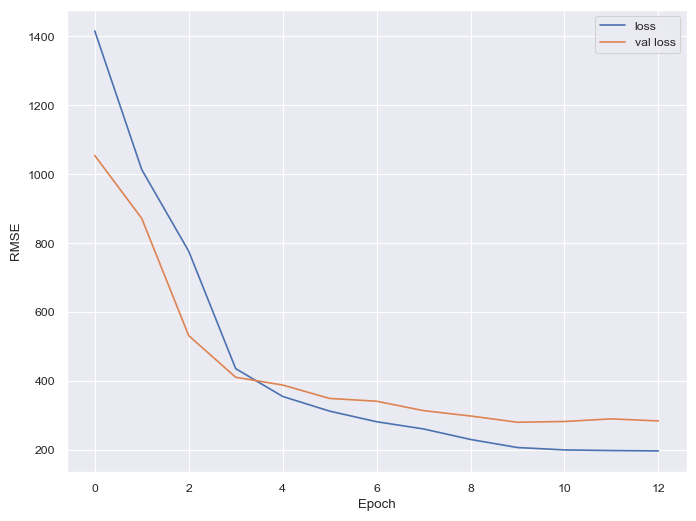

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    x=range(len(history.history["loss"])),
    y=np.sqrt(history.history["loss"]),
    ax=ax,
    label="loss",
)
sns.lineplot(
    x=range(len(history.history["val_loss"])),
    y=np.sqrt(history.history["val_loss"]),
    ax=ax,
    label="val loss",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")

In [27]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

2393/2393 [==============================] - 10s 4ms/step


In [28]:
mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)

285.4934

Looks as though the neural net actually performs quite a bit better than classic ML algorithms, achieving a loss of around 300 kW. This is pretty good for now, so we'll save it and move on. 

In [29]:
model.save(MODEL_SAVE_DIR)

INFO:tensorflow:Assets written to: /Users/jamesmoro/Documents/Python/Energy-Forecasting/models/saved_model/assets


INFO:tensorflow:Assets written to: /Users/jamesmoro/Documents/Python/Energy-Forecasting/models/saved_model/assets


## Removing bulb temps

it looks difficult to find forecasts with min/max wet bulb temperature, so I'm going to remove these features and test the response metrics. 

In [13]:
cols_to_keep = [x for x in X_train.columns if "Bulb" not in x]

In [14]:
cols_to_keep

['Min Temp',
 'Max Temp',
 'Time Stamp',
 'PTID',
 'Year',
 'Month',
 'Day',
 'Minute',
 'Hour',
 'Month_sin',
 'Month_cos',
 'Day_sin',
 'Day_cos',
 'Minute_sin',
 'Minute_cos',
 'Hour_sin',
 'Hour_cos']

In [15]:
X_train_reduced = X_train[cols_to_keep]
X_test_reduced = X_test[cols_to_keep]

In [16]:
X_train_reduced.head()

,Min Temp,Max Temp,Time Stamp,PTID,Year,Month,Day,Minute,Hour,Month_sin,Month_cos,Day_sin,Day_cos,Minute_sin,Minute_cos,Hour_sin,Hour_cos
0,1.58,1.22,-1.75,1.29,-1.81,0.68,-0.88,-1.59,-1.66,-1.40,-0.04,1.40,-0.05,0.00,1.38,0.00,1.33
1,1.37,1.14,-1.75,0.98,-1.81,0.68,-0.88,-1.59,-1.66,-1.40,-0.04,1.40,-0.05,0.00,1.38,0.00,1.33
2,1.19,1.13,-1.75,0.06,-1.81,0.68,-0.88,-1.59,-1.66,-1.40,-0.04,1.40,-0.05,0.00,1.38,0.00,1.33
3,0.89,0.80,-1.75,-0.55,-1.81,0.68,-0.88,-1.59,-1.66,-1.40,-0.04,1.40,-0.05,0.00,1.38,0.00,1.33
4,0.94,0.83,-1.75,-0.25,-1.81,0.68,-0.88,-1.59,-1.66,-1.40,-0.04,1.40,-0.05,0.00,1.38,0.00,1.33


In [17]:
model = keras.Sequential(
    [
        layers.Dense(32, activation="relu", input_shape=(X_train_reduced.shape[1],)),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation = 'relu'),
    ]
)

model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(0.001))
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, min_delta=1000
)
NUM_EPOCHS = 50
BATCH_SIZE = 2**9  # 1024

history = model.fit(
    X_train_reduced,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_test_reduced, y_test),
    callbacks=[callback],
)

Epoch 1/50
19141/19141 [==============================] - 123s 6ms/step - loss: 1307760.3750 - val_loss: 360313.8750
Epoch 2/50
19141/19141 [==============================] - 138s 7ms/step - loss: 170954.2031 - val_loss: 184840.7969
Epoch 3/50
19141/19141 [==============================] - 111s 6ms/step - loss: 122429.3281 - val_loss: 176968.9375
Epoch 4/50
19141/19141 [==============================] - 109s 6ms/step - loss: 110595.7266 - val_loss: 172577.9531
Epoch 5/50
19141/19141 [==============================] - 109s 6ms/step - loss: 100970.6562 - val_loss: 190122.4219
Epoch 6/50
19141/19141 [==============================] - 107s 6ms/step - loss: 85415.0078 - val_loss: 198672.6562
Epoch 7/50
19141/19141 [==============================] - 128s 7ms/step - loss: 81750.5703 - val_loss: 206968.1094
Epoch 8/50
19141/19141 [==============================] - 113s 6ms/step - loss: 81206.6484 - val_loss: 206803.5938
Epoch 9/50
19141/19141 [==============================] - 105s 5ms/step - 

Text(0, 0.5, 'RMSE')

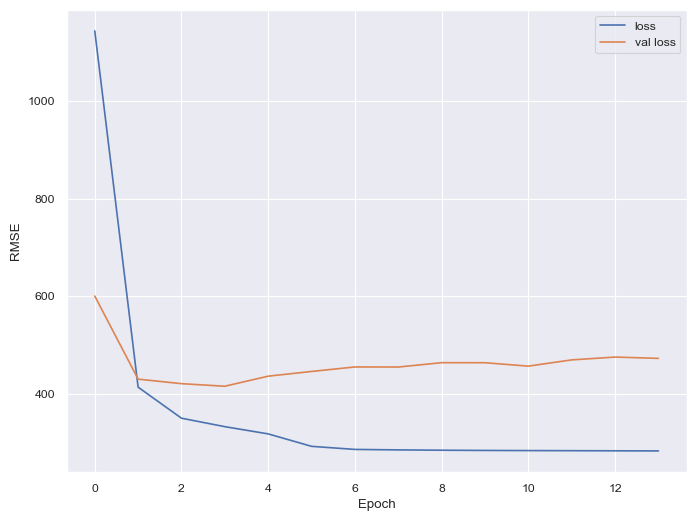

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    x=range(len(history.history["loss"])),
    y=np.sqrt(history.history["loss"]),
    ax=ax,
    label="loss",
)
sns.lineplot(
    x=range(len(history.history["val_loss"])),
    y=np.sqrt(history.history["val_loss"]),
    ax=ax,
    label="val loss",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")

In [20]:
y_pred = model.predict(X_test_reduced, batch_size=BATCH_SIZE)

9571/9571 [==============================] - 53s 5ms/step


In [21]:
mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)

472.5009

Slightly lower scores (even with lower batch size), which isn't too surprising, but based on the overall average of the load values, 340 kW isnt too bad. 
Given the difficulty in finding bulb temps in forecasts I think I'll just go with this model. 

In [25]:
X_test_reduced['pred_load'] = y_pred

<Axes: >

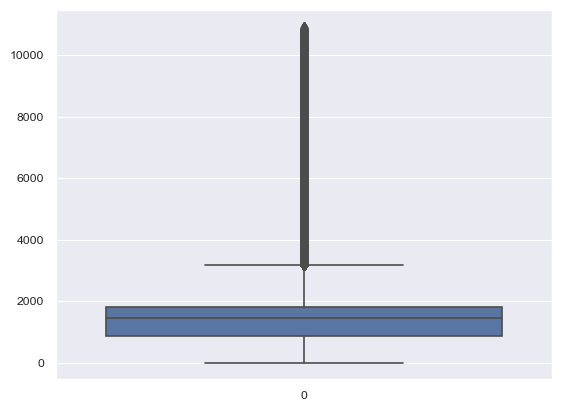

In [33]:
sns.boxplot(X_test_reduced['pred_load'])

In [34]:
model.save(MODEL_SAVE_DIR)

INFO:tensorflow:Assets written to: /Users/jamesmoro/Documents/Python/Energy-Forecasting/models/saved_model/assets


INFO:tensorflow:Assets written to: /Users/jamesmoro/Documents/Python/Energy-Forecasting/models/saved_model/assets
